# Affine Faces

## Some experiements with People Blending and Generative Art

Hello! In this tutorial, I will show you how to create an artistic images of a person by automatically superimposing a series of photographs. The key idea is that we will superimpose photographs in such a way that major facial landmarks (such as eyes) coinside, creating a realistic image of a face, but unrealistic and blended surroundings. 

Examples of such images are given below:

| ![](img/PhoBoGuy.png) | ![](img/PhoBoGuy1.png) |
|-----------------------|------------------------|


### Some pre-requisites

We are going to do some image manipulations here, so we need OpenCV. It might not be included into our Python distribution, so to be on the safe side we will `pip`-install it. In addition, we would need `matplotlib` to show our results.

In [1]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install mPyPl
import cv2
import pickle
import matplotlib.pyplot as plt
import mPyPl as mp
from mPyPl.utils.image import show_images, im_load

Requirement already up-to-date: mPyPl in c:\winapp\miniconda3\lib\site-packages (0.0.3.8)


### Extracting Facial Landmarks

To extract facial landmarks, we will use [Microsoft Face API](https://azure.microsoft.com/services/cognitive-services/face/?wt.mc_id=art-blog-dmitryso). It provides a simple REST API that can extract a lot of useful information from the face image, including those landmarks:

![Facial Landmarks](img/landmarks.jpg)

It is quite easy to call Face API directly via REST, but it is even better to use existing SDK, which is available for Python as part of [Azure SDK library](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/quickstarts/python-sdk?wt.mc_id=art-blog-dmitryso).

You can [visit Microsoft Docs](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/index/?wt.mc_id=art-blog-dmitryso) for more detailed information on Face API and using it from languages other than Python.

In [ ]:
!{sys.executable} -m pip install azure-cognitiveservices-vision-face

To use Face API, we need to provide a key and endpoint URL (because it is available in different regions, URL can be different). There are many ways to obtain Face API Key:

* If you have an Azure Subscription, the best option is to create Cognitive Services resource, and grab key/url from there
* If you do not have an Azure Subscription, you can try Face API for free - request your trial key [here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&wt.mc_id=art-blog-dmitryso).

**Important:** If you use trial key, your Face API will have some limitations, in terms of number of images you can process, and frequency of API calls (not more than 20 calls per minute). In order to make things work, we would need to insert some pauses in between calls, when using API on a series of images.

After you get the key and endpoint, please insert them into the cell below. There would typically be two keys given on the portal, you can use any one of them.

In [50]:
key = 'e408f9b6c8e34aee8f5567dbea67df30'
endpoint = 'https://westeurope.api.cognitive.microsoft.com/'

Most of the calls of the Face API are done through the static module `cognitive_face`, which we will call `cf` for brevity.

In [51]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

The main function for face detection is called `face.detect_with_url` or `face.detect_with_stream`. It can extract a lot of useful information from the face, depending on the parameters that you specify - in our case we would need facial landmarks:

In [52]:
res = cli.face.detect_with_url('https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg')
with open('img/soshnikov.jpg','r+b') as f:
    res = cli.face.detect_with_stream(f,return_face_landmarks=True)

print(res[0])

{'additional_properties': {}, 'face_id': '894e4cff-1bbe-4340-9dc2-bfe1cf508c6a', 'recognition_model': None, 'face_rectangle': <azure.cognitiveservices.vision.face.models._models_py3.FaceRectangle object at 0x000002102D80F6C8>, 'face_landmarks': <azure.cognitiveservices.vision.face.models._models_py3.FaceLandmarks object at 0x000002102D80FE08>, 'face_attributes': None}


In [58]:
print(res[0].face_landmarks.as_dict())

{'pupil_left': {'x': 112.6, 'y': 126.7}, 'pupil_right': {'x': 170.9, 'y': 118.9}, 'nose_tip': {'x': 148.7, 'y': 158.4}, 'mouth_left': {'x': 121.6, 'y': 182.6}, 'mouth_right': {'x': 177.8, 'y': 172.1}, 'eyebrow_left_outer': {'x': 84.1, 'y': 120.3}, 'eyebrow_left_inner': {'x': 122.9, 'y': 110.1}, 'eye_left_outer': {'x': 103.3, 'y': 128.9}, 'eye_left_top': {'x': 112.3, 'y': 122.8}, 'eye_left_bottom': {'x': 113.7, 'y': 131.4}, 'eye_left_inner': {'x': 122.4, 'y': 126.7}, 'eyebrow_right_inner': {'x': 157.2, 'y': 106.3}, 'eyebrow_right_outer': {'x': 192.1, 'y': 106.6}, 'eye_right_inner': {'x': 162.7, 'y': 120.8}, 'eye_right_top': {'x': 171.3, 'y': 115.0}, 'eye_right_bottom': {'x': 172.7, 'y': 123.5}, 'eye_right_outer': {'x': 181.5, 'y': 118.5}, 'nose_root_left': {'x': 135.4, 'y': 126.3}, 'nose_root_right': {'x': 151.5, 'y': 124.3}, 'nose_left_alar_top': {'x': 131.9, 'y': 147.4}, 'nose_right_alar_top': {'x': 158.4, 'y': 143.8}, 'nose_left_alar_out_tip': {'x': 128.2, 'y': 159.3}, 'nose_right_al

Now to see this all in action, we will plot facial landmarks point over the face:

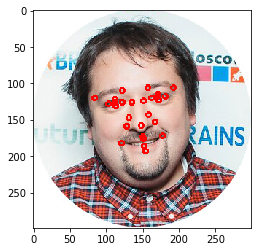

In [7]:
img = im_load('img/soshnikov.jpg')
for k,v in res[0].face_landmarks.as_dict().items():
    cv2.circle(img,(int(v['x']),int(v['y'])),3,(255,0,0),2)
plt.imshow(img)

### Getting some images

We need some images to play with. In this example, we will take 50 images of Bill Gates obtained from [Bing Image Search]((https://docs.microsoft.com/en-us/azure/cognitive-services/bing-image-search/index/?wt.mc_id=art-blog-dmitryso). We will place them into `images` directory of this notebook. If you wish to experiment with your own pictures, just upload them into `images` directory using Azure Notebooks file upload feature. **NB:** this will take a while, and you need to wait for this cell to finish execution before proceeding.

In [10]:
import os
if not os.path.isdir('images'):
    !mkdir images
    !wget https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip
    !unzip -q Gates50.zip -d images
    !rm Gates50.zip

--00:08:50--  https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip
           => `Gates50.zip'
Resolving github.com... 140.82.118.4
Connecting to github.com|140.82.118.4|:443... connected.
OpenSSL: error:1407742E:SSL routines:SSL23_GET_SERVER_HELLO:tlsv1 alert protocol version
Unable to establish SSL connection.
unzip:  cannot find or open Gates50.zip, Gates50.zip.zip or Gates50.zip.ZIP.
rm: cannot remove 'Gates50.zip': No such file or directory


For our further experiments, let's load 10 first images, and run them through Face API to obtain facial landmarks. We will save the images into `images` array, and landmarks data into `imagepoints`.

In [59]:
def detect(fn):
    with open(fn,'rb') as f:
        return cli.face.detect_with_stream(f,return_face_landmarks=True)

data = (mp.get_files("images")
        | mp.as_field('filename')
        | mp.apply('filename','image',im_load)
        | mp.apply('filename','meta',detect)
        | mp.iter('filename',lambda x: print("Processing {}".format(x)))
        | mp.filter('meta',lambda x: x is not None and len(x)>0)
        | mp.apply('meta','faceland',lambda x: x[0].face_landmarks.as_dict())
        | mp.as_list)

print(data[0])

Processing images\gates_0.jpg
Processing images\gates_1.jpg
Processing images\gates_10.jpg
Processing images\gates_11.jpg
Processing images\gates_12.jpg
Processing images\gates_13.jpg
Processing images\gates_14.jpg
Processing images\gates_15.jpg
Processing images\gates_16.jpg
Processing images\gates_17.jpg
Processing images\gates_19.jpg
Processing images\gates_2.jpg
Processing images\gates_21.jpg
Processing images\gates_22.jpg
Processing images\gates_23.jpg
Processing images\gates_24.jpg
Processing images\gates_25.jpg
Processing images\gates_26.jpg
Processing images\gates_27.jpg
Processing images\gates_28.jpg
Processing images\gates_29.jpg
Processing images\gates_3.jpg
Processing images\gates_30.jpg
Processing images\gates_31.jpg
Processing images\gates_33.jpg
Processing images\gates_34.jpg
Processing images\gates_35.jpg
Processing images\gates_36.jpg
Processing images\gates_37.jpg
Processing images\gates_38.jpg
Processing images\gates_39.jpg
Processing images\gates_4.jpg
Processing im

We can store the result to temp file, so that later on we can retrieve it w/out the need to call Face API. This allows to show the demo offline.

In [60]:
with open('c:/temp/peopleblending.pkl','wb') as f:
    pickle.dump(data,f)

with open('c:/temp/peopleblending.pkl','rb') as f:
    data=pickle.load(f)

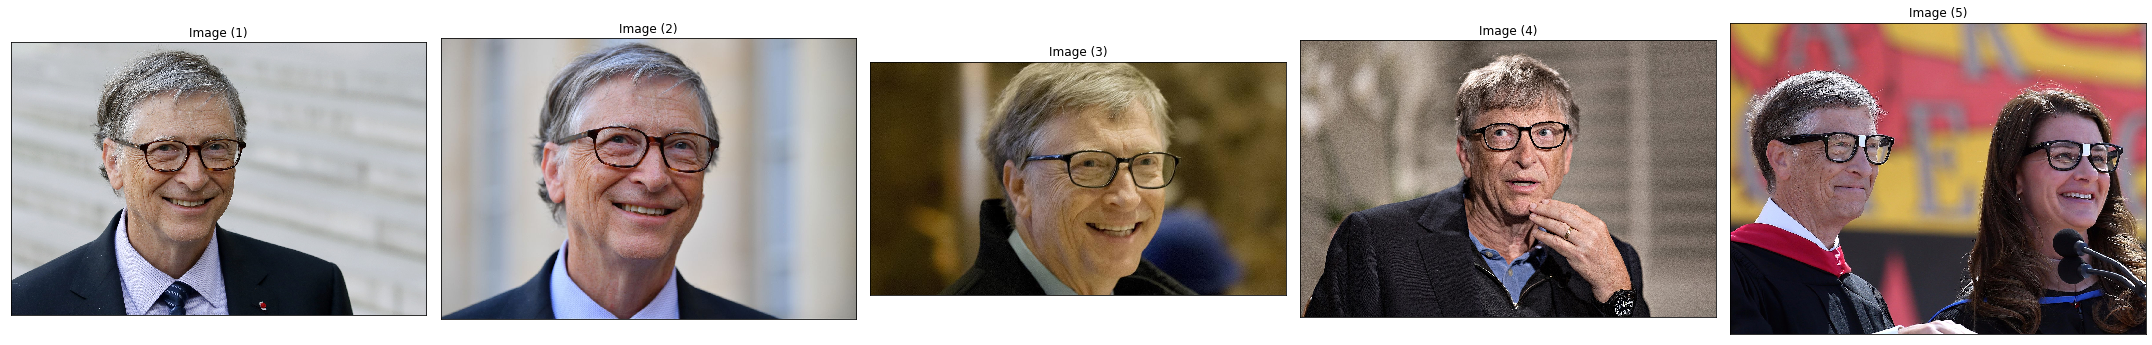

In [71]:
(data | mp.pshuffle | mp.take(5) | mp.select_field('image') | mp.pexec(show_images))

## Affine Transformations

To get images all aligned, we need to position and rescale them according to the positions of eyes. To do that, we will use so-called [**affine transformation**](https://en.wikipedia.org/wiki/Affine_transformation). It includes many common image operations, such as scaling, rotation, skew, etc.

Such transformation can be defined in 2D-space using a matrix, and if we want to compute coordinates of a point after the transformation, we need to multiply them by this matrix. More precisely,
$$
\left(\begin{matrix}x'\cr y'\cr 1\end{matrix}\right) = M\times\left(\begin{matrix}x\cr y\cr 1\end{matrix}\right)
$$

In our case, we want to generate well-aligned portraits with eyes located at exactly the same position. Suppose the target image size is $300\times300$, then we can position eyes at points $(130,120)$ and $(170,120)$. 

It is known that affine transformation in 2D space can be uniquely defined by 3 points, i.e. we need to specify target coordinates for 3 given points in the image. In our case two such points will be left and right eye, and we need to chose the third point. A good choice would be to use some central point in the mouth, for example an average point between `mouth_left` and `mouth_right`.

In OpenCV, an affine transformation that maps given 3 points to another set of 3 points can be computed using `getAffineTransform` function. The resulting transformation can be applied to the whole image using `warpAffine` (and it also cuts out the remaining portions of the image, so that it fits the rectangle of the given size). 

Thus, the function to rotate our images to the fixes eyes-mouth position can be defined as follows:

In [62]:
import numpy as np

target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))

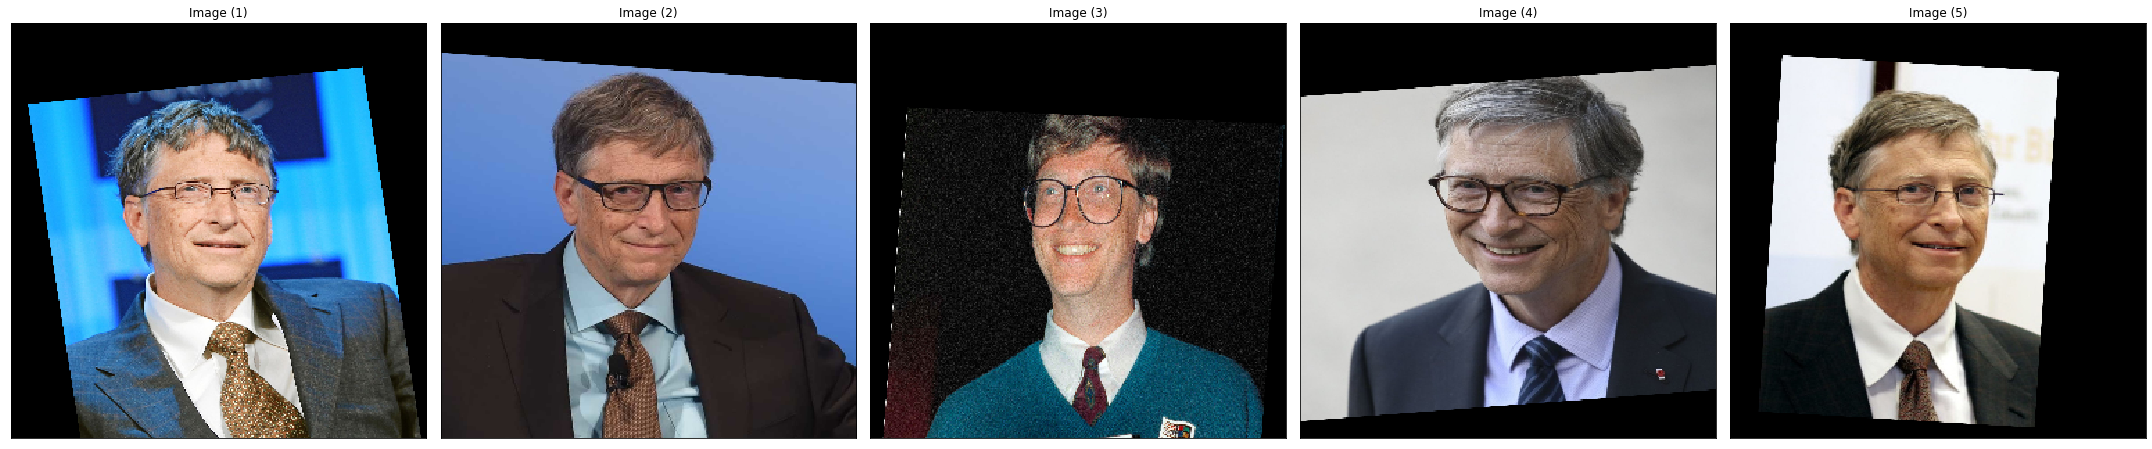

In [73]:
data_al = data | mp.apply(['image','faceland'],'aligned',lambda x: affine_transform(*x)) | mp.as_list

data_al | mp.pshuffle | mp.take(5) | mp.select_field('aligned') | mp.pexec(show_images)

## Image Blending

Now we need to blend those images together to produce a nice result. Since images are represented in Python as `numpy` 3D-arrays, it is a simple operation of computing weighted average of those arrays. So, for two images $A$ and $B$, blended image can be computed as $C_{i,j,c} = \frac{1}{2}(A_{i,j,c}+B_{i,j,c})$ (here we denote by $c$ a color channel, so that $c\in\{1,2,3\}$).

In more general case, if $I^{(1)}, I_{(2)}, \dots, I_{(n)}$ are the images, and we want to blend them with different weights $\alpha_1, \alpha_2, \dots, \alpha_n$, such that $\alpha_1+\alpha_2+\dots+\alpha_n=1$, then the resulting merged image is computed as 
$$
M_{i,j,c} = \sum_{k=1}^n\alpha_k I^{(k)}_{i,j,c}
$$

In [74]:
def merge(images,wts=None):
    images = list(images)
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    return res.astype(np.int32)

In this function, if we do not specify weights vector - it is automatically assumed to be uniform.

Let's see how this function works for mixing two images:

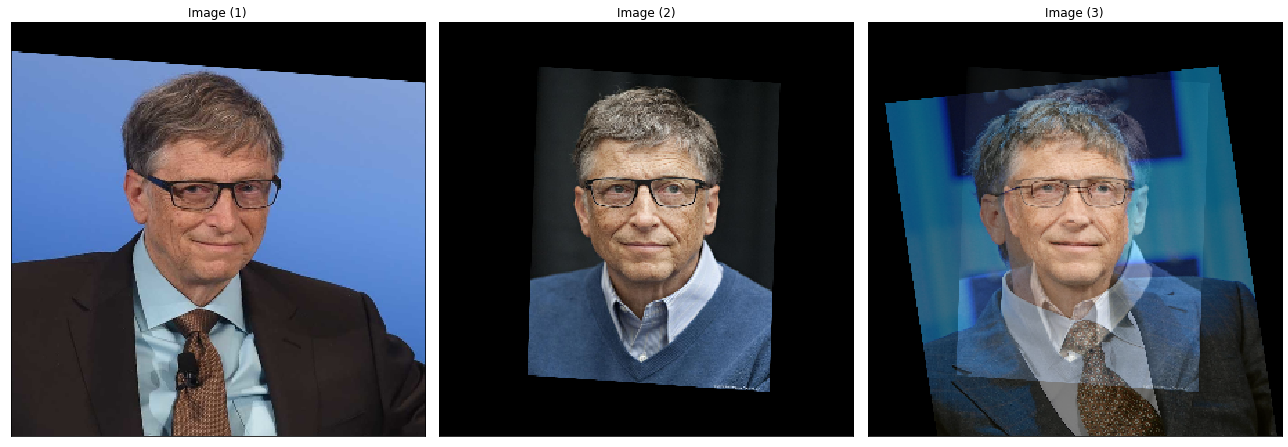

In [75]:
show_images([data_al[2]['aligned'],data_al[6]['aligned'],merge([data_al[0]['aligned'],data_al[6]['aligned']])])

Now let's merge all aligned images altogether and see what happens:

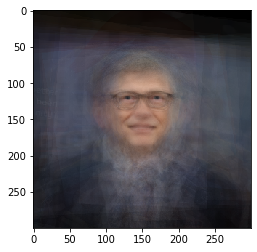

In [76]:
res = data_al | mp.select_field('aligned') | mp.pexec(merge)
plt.imshow(res)

## Generating several merged images

Sometimes to get a nice piece of generative art we need to have a few pieces to select from. To do this, we can generate a number of randomly blended images - varying both images used during blending and their weights. А function `generate_from` defined below is used to generate blended images from `n` randomly chosen images from our collection. To make a selection of images more diverse, it makes sense to increase the number of images in our collection (which will lead to more Face API calls, and the need to prevent overflowing API if we are using free tier).

Here are a few random pictures generated from 5 images with random blending:

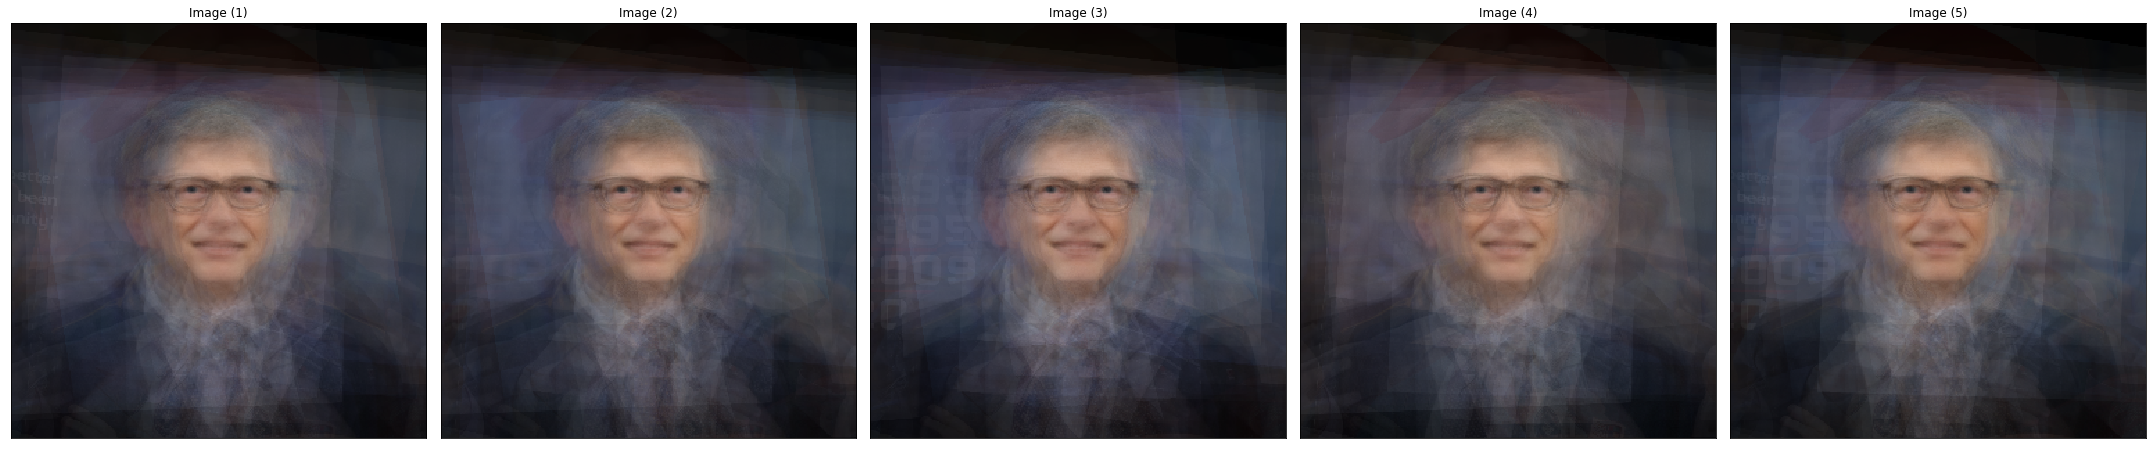

In [67]:
import functools

def rndmerge(n=None):
    if n is None: n = len(data_al)
    return (data_al | mp.pshuffle | mp.take(n) 
            | mp.select_field('aligned') 
            | mp.pexec(functools.partial(merge,wts=np.random.random(n))))

range(5) | mp.select(lambda _ : rndmerge()) | mp.pexec(show_images)

And in the sample below we take $n=3$:

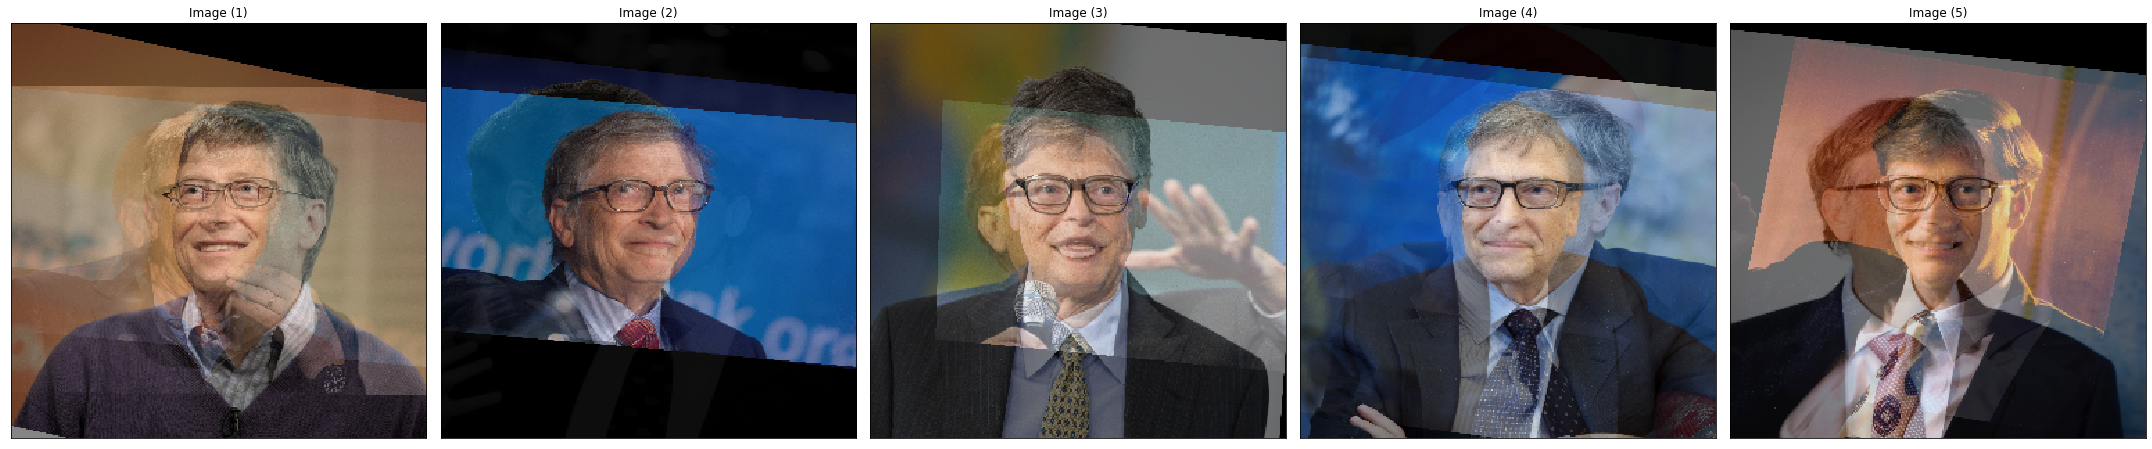

In [68]:
range(5) | mp.select(lambda _ : rndmerge(3)) | mp.pexec(show_images)

And for $n=5$:

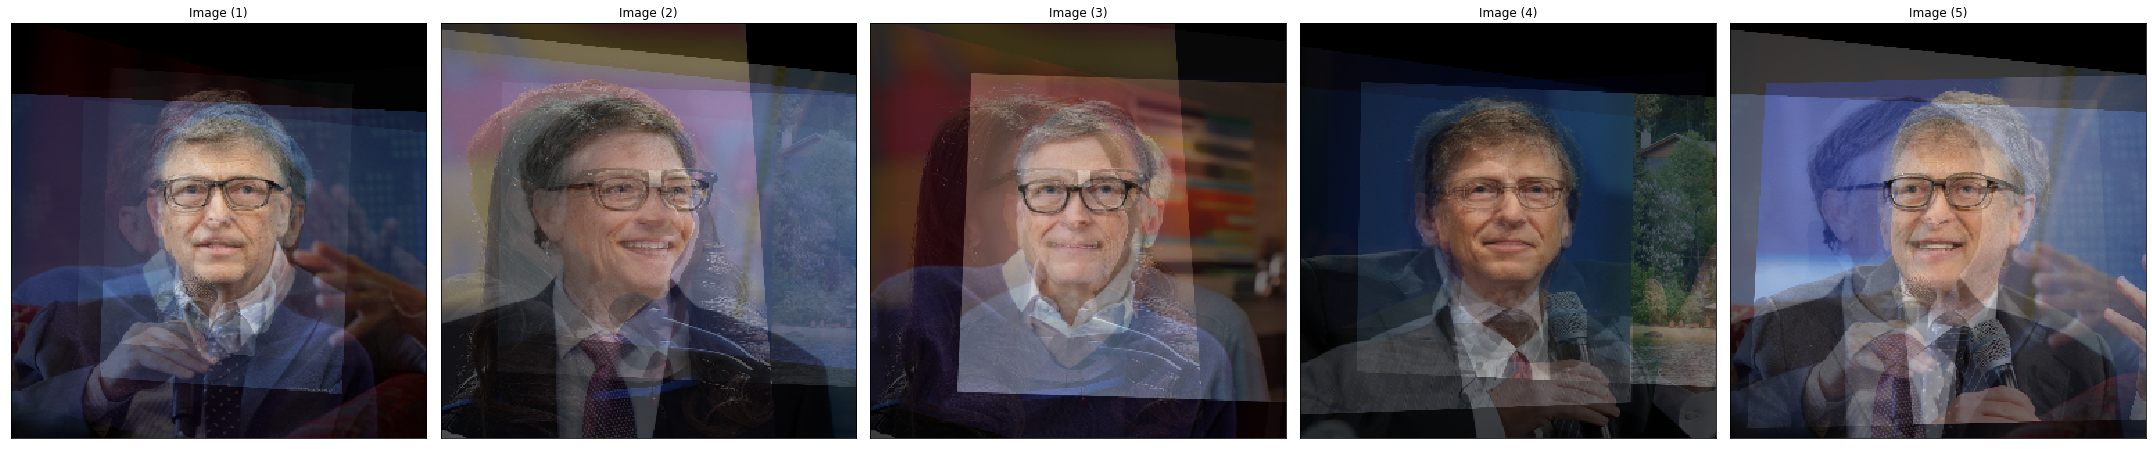

In [69]:
range(5) | mp.select(lambda _ : rndmerge(5)) | mp.pexec(show_images)